# Measure a Profile

## Note

All functions in this section using the cluster object as first argument are also internal functions of the cluster object, and should be used as such. They are just explicitely used here for clarity.

Ex:

```
theta, g_t, g_x = compute_tangential_and_cross_components(cl, geometry="flat")
```

should be done by the user as:

```
theta, g_t, g_x = cl.compute_tangential_and_cross_components(geometry="flat")
```

In [1]:
import matplotlib.pyplot as plt
import clmm
import clmm.polaraveraging
from clmm.polaraveraging import compute_tangential_and_cross_components, make_binned_profile, make_bins
from clmm.plotting import plot_profiles
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import sys
sys.path.append('./support')
import mock_data as mock

Make sure we know which version we're using

In [2]:
clmm.__version__

'0.3.0'

### Define cosmology object

In [3]:
from astropy.cosmology import FlatLambdaCDM
mock_cosmo = FlatLambdaCDM(H0=70., Om0=0.3, Ob0=0.025)

## 1. Generate cluster object from mock data
In this example, the mock data includes: shape noise, galaxies drawn from redshift distribution and photoz errors.

Define toy cluster parameters for mock data generation

In [4]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000
Delta = 200

zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            ngals,
                                            Delta,
                                            'chang13',
                                            zsrc_min = zsrc_min,
                                            shapenoise=0.005,
                                            photoz_sigma_unscaled=0.05)

Loading this into a CLMM cluster object centered on (0,0)

In [5]:
cluster_ra = 0.0
cluster_dec = 0.0
cl = GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, noisy_data_z)

### 2. Load cluster object containing:
> Lens properties (ra_l, dec_l, z_l)

> Source properties (ra_s, dec_s, e1, e2)
### Note, if loading from mock data, use: 
>> cl = gc.load_cluster("GC_from_mock_data.pkl")

In [6]:
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra,
      "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 1000


## 2. Basic checks and plots 
- galaxy positions
- redshift distribution

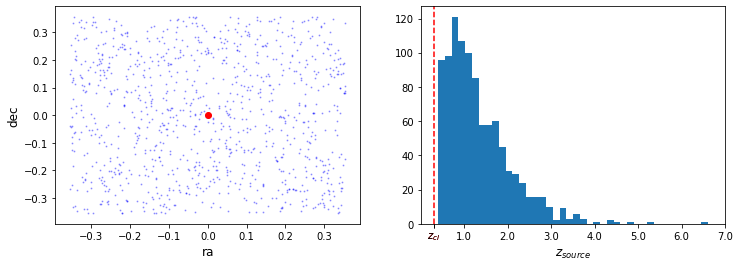

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(cl.galcat['ra'], cl.galcat['dec'], color='blue', s=1, alpha=0.3)
ax[0].plot(cl.ra, cl.dec, 'ro')
ax[0].set_ylabel('dec', fontsize="large")
ax[0].set_xlabel('ra', fontsize="large")

hist = ax[1].hist(cl.galcat['z'], bins=40)[0]
ax[1].axvline(cl.z, c='r', ls='--')
ax[1].set_xlabel('$z_{source}$', fontsize="large")
xt = {t:f'{t}' for t in ax[1].get_xticks() if t!=0}
xt[cl.z] ='$z_{cl}$'
xto = sorted(list(xt.keys())+[cl.z])
ax[1].set_xticks(xto)
ax[1].set_xticklabels(xt[t] for t in xto)
ax[1].get_xticklabels()[xto.index(cl.z)].set_color('red')
plt.xlim(0, max(xto))
plt.show()

- Check ellipticities

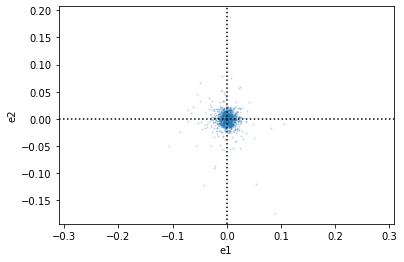

In [8]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(cl.galcat['e1'], cl.galcat['e2'], s=1, alpha=0.2)
ax1.set_xlabel('e1')
ax1.set_ylabel('e2')
ax1.set_aspect('equal', 'datalim')
ax1.axvline(0, linestyle='dotted', color='black')
ax1.axhline(0, linestyle='dotted', color='black')

## 3. Compute and plot shear profiles

### 3.1 Compute angular separation, cross and tangential shear for each source galaxy

- By defaut, `compute_tangential_and_cross_components` uses columns named `e1` and `e2` of the `galcat` table

In [9]:
theta, e_t, g_x = compute_tangential_and_cross_components(cl, geometry="flat",add_to_cluster=True)
# With the option add_to_cluster the cl object has theta, et and ex new columns 
# (default: takes in columns named 'e1' and 'e2' and save the results in 'et' and 'ex')
cl

GalaxyCluster Awesome_cluster: (ra=0.0, dec=0.0) at z=0.3
> 1000 source galaxies
> With columns: ra dec e1 e2 z pzbins pzpdf id theta et ex

- But it's also possible to choose which columns to use for input and output, e.g. Below we're storing the results in `e_tan` and `e_cross` instead (explicitely taking `e1` and `e2` as input)


In [10]:
theta, e_t, g_x = compute_tangential_and_cross_components(cl, geometry="flat",
                                                      shape_component1='e1', shape_component2='e2', 
                                                      tan_component='e_tan', cross_component='e_cross',
                                                      add_to_cluster=True)
cl

GalaxyCluster Awesome_cluster: (ra=0.0, dec=0.0) at z=0.3
> 1000 source galaxies
> With columns: ra dec e1 e2 z pzbins pzpdf id theta et ex e_tan e_cross

Plot tangential and cross ellipticity distributions for verification, which can be accessed in the galaxy cluster object, cl.

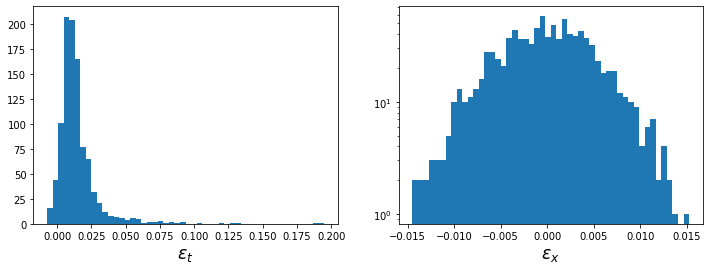

In [11]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(cl.galcat['et'],bins=50)
ax[0].set_xlabel('$\\epsilon_t$',fontsize='xx-large')

ax[1].hist(cl.galcat['ex'],bins=50)
ax[1].set_xlabel('$\\epsilon_x$',fontsize='xx-large')
ax[1].set_yscale('log')

Compute transversal and cross shear profiles in units defined by user, using defaults binning 

### 3.2 Compute shear profile in radial bins
Given the separations in "radians" computed in the previous step, the user may ask for a binned profile in various projected distance units. The astropy table corresponding to the binning profiled is attached as a new attribute of the galaxy cluster object.
#### 3.2.1 Default binning
- default binning using kpc:

In [12]:
profiles = make_binned_profile(cl, "radians", "kpc", cosmo=cosmo)
cl.profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
83.67188812246332,544.3989212915044,871.1017195811847,0.08536199383403656,0.008165855958494964,0.0005314521866633044,0.0010949989275967564,1.3274043346521212,0.11426494268331078,25
871.1017195811847,1285.6453692731375,1658.5315510399062,0.04184316951847686,0.0015409505742970343,-0.0010531975450252399,0.0007749486088288471,1.2908261941872718,0.09653672305148797,50
1658.5315510399062,2060.706445063783,2445.9613824986277,0.023736189919500758,0.00099031606224811,0.0010564104147240299,0.0005496812730333596,1.231447153603926,0.10105451571640815,67
2445.9613824986277,2871.6583313806364,3233.391213957349,0.017895924915336998,0.0006463430420883409,-0.00025021048326343844,0.0005052005808219813,1.2589606287402832,0.05811389037004324,113
3233.391213957349,3638.4227035400545,4020.8210454160703,0.013808153747514786,0.00047345634395360483,-8.111685816888414e-05,0.0004450561337789406,1.4027312794224653,0.06645966197136836,130
4020.8210454160703,4422.071326836728,4808.250876874792,0.010462294624596911,0.0003964108181419827,0.00022665040595245585,0.0004024491554318752,1.341544460658194,0.06041714633239694,159
4808.250876874792,5220.394712913828,5595.680708333513,0.008184412732151066,0.0004134709685610619,-0.0002869309954543291,0.00037356445227227996,1.314928256129007,0.058141590857127154,182
5595.680708333513,5917.104495620981,6383.110539792235,0.00800056593641444,0.00044401946301301425,-3.2003457774763996e-05,0.00039779429983397317,1.379688967699525,0.06224317704976149,172
6383.110539792235,6747.215631005166,7170.540371250956,0.0064521819739096885,0.0006229847079850718,0.0005056799314938842,0.0005380734836233823,1.417750590653028,0.07844348656555358,75


Use function to plot the profiles

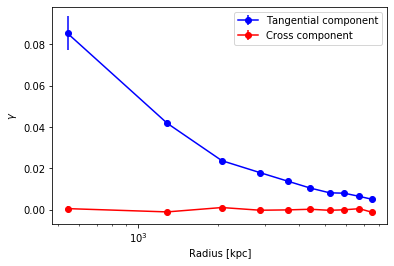

In [13]:
fig, ax = plot_profiles(cl,xscale='log')

- default binning using degrees:

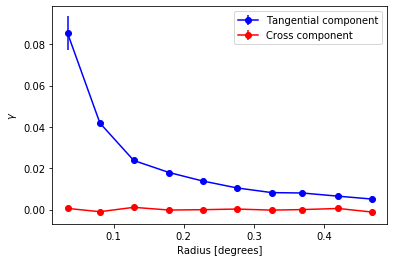

In [14]:
new_profiles = make_binned_profile(cl, "radians", "degrees",cosmo=cosmo)
fig1, ax1 = plot_profiles(cl, "degrees")

#### 3.2.2 User-defined binning 
The users may also provide their own binning, in user-defined units, to compute the transversal and cross shear profiles. The `make_bins` function is provided in `utils.py` and allow for various options. 

- e.g., generate 20 bins between 1 and 6 Mpc, linearly spaced.

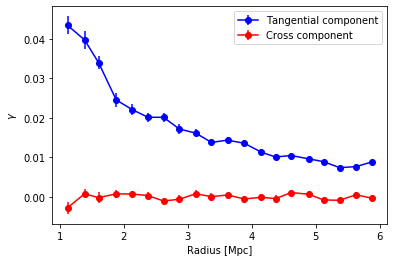

In [15]:
new_bins = make_bins(1, 6, nbins=20, method='evenwidth')

# Make the shear profile in this binning
new_profiles = make_binned_profile(cl, "radians", "Mpc",
                                  bins=new_bins, cosmo=cosmo)

fig1, ax1 = plot_profiles(cl, "Mpc", r_units='Mpc')

- e.g., generate 20 bins between 1 and 6 Mpc, evenly spaced in log space.

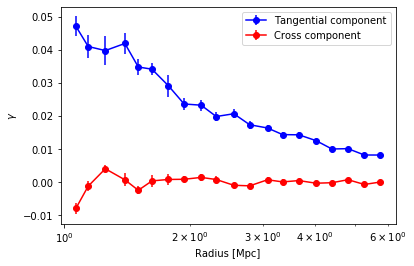

In [16]:
new_bins = make_bins(1, 6, nbins=20, method='evenlog10width')

new_profiles = make_binned_profile(cl, "radians", "Mpc",
                                  bins=new_bins, cosmo=cosmo)
fig1, ax1 = plot_profiles(cl, "Mpc", r_units='Mpc')
ax1.set_xscale('log')

- e.g., generate 20 bins between 1 and 6 Mpc, each contaning the same number of galaxies

number of galaxies in each bin: [41, 40, 41, 40, 40, 41, 40, 41, 40, 40, 41, 40, 41, 40, 40, 41, 40, 41, 40, 41]


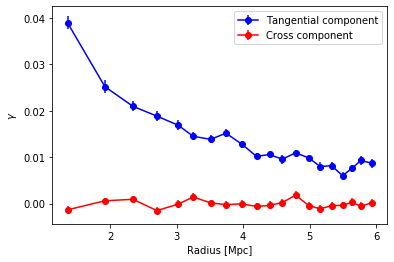

In [17]:
# First, convert the source separation table to Mpc
seps = u.convert_units(cl.galcat["theta"], "radians", "Mpc", redshift=cl.z, cosmo=cosmo)

new_bins = make_bins(1, 6, nbins=20, method='equaloccupation', source_seps=seps)
new_profiles = make_binned_profile(cl, "radians", "Mpc",bins=new_bins, cosmo=cosmo)

print(f"number of galaxies in each bin: {list(cl.profile['n_src'])}")
fig1, ax1 = plot_profiles(cl, "Mpc", r_units='Mpc')

#### 3.2.3 Other individual profile quantities may also be accessed 

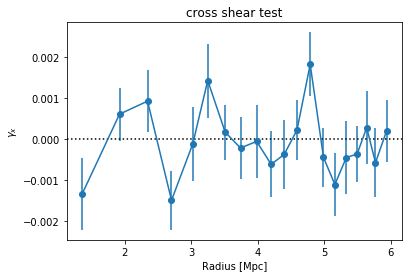

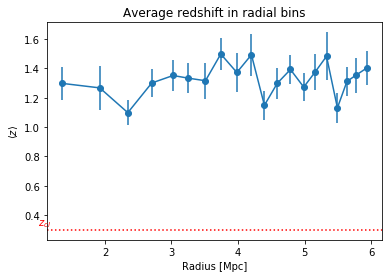

In [18]:
plt.title('cross shear test')
plt.errorbar(new_profiles['radius'], new_profiles['gx'],
             new_profiles['gx_err'], marker = 'o')
plt.axhline(0, linestyle='dotted', color='black')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\\gamma_x$')
plt.show()

plt.title('Average redshift in radial bins')
plt.errorbar(new_profiles['radius'], new_profiles['z'],
             new_profiles['z_err'], marker = 'o')
plt.axhline(cl.z, linestyle='dotted', color='r')
plt.text(1, cl.z*1.1, '$z_{cl}$', color='r')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\langle z\\rangle$')
plt.show()

## 4. Focus on some options of `make_binned_profile`
### 4.1. `gal_ids_in_bins` 
The `gal_ids_in_bins` option adds a `gal_id` field to the profile astropy table. For each bin of the profile, this is filled with the list of galaxy IDs for the galaxies that have fallen in that bin.

In [19]:
profiles = make_binned_profile(cl, "radians", "Mpc", cosmo=cosmo, gal_ids_in_bins=True)

In [20]:
# Here the list of galaxy IDs that are in the first bin of the tangential shear profile
import numpy as np
gal_list = profiles['gal_id'][0]
print(gal_list)

[29, 48, 80, 102, 108, 168, 251, 303, 366, 383, 404, 417, 506, 513, 524, 528, 544, 612, 635, 725, 803, 816, 856, 888, 989]


### 4.2. User-defined naming scheme
The user may specify which columns to use from the `galcat` table to perform the binned average. If none is specified, the code looks for columns names `et` and `ex`. Below, we average in bins the columns`e_tan` and `e_cross` of `galcat` and store the results in the columns `g_tan` and `g_cross` of the `profile` table of the cluster object.

In [21]:
cl.make_binned_profile("radians", "kpc", cosmo=cosmo, 
                       tan_component_in='e_tan', cross_component_in='e_cross',
                       tan_component_out='g_tan', cross_component_out='g_cross');
cl.profile

radius_min,radius,radius_max,g_tan,g_tan_err,g_cross,g_cross_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
83.67188812246332,544.3989212915044,871.1017195811847,0.08536199383403656,0.008165855958494964,0.0005314521866633044,0.0010949989275967564,1.3274043346521212,0.11426494268331078,25
871.1017195811847,1285.6453692731375,1658.5315510399062,0.04184316951847686,0.0015409505742970343,-0.0010531975450252399,0.0007749486088288471,1.2908261941872718,0.09653672305148797,50
1658.5315510399062,2060.706445063783,2445.9613824986277,0.023736189919500758,0.00099031606224811,0.0010564104147240299,0.0005496812730333596,1.231447153603926,0.10105451571640815,67
2445.9613824986277,2871.6583313806364,3233.391213957349,0.017895924915336998,0.0006463430420883409,-0.00025021048326343844,0.0005052005808219813,1.2589606287402832,0.05811389037004324,113
3233.391213957349,3638.4227035400545,4020.8210454160703,0.013808153747514786,0.00047345634395360483,-8.111685816888414e-05,0.0004450561337789406,1.4027312794224653,0.06645966197136836,130
4020.8210454160703,4422.071326836728,4808.250876874792,0.010462294624596911,0.0003964108181419827,0.00022665040595245585,0.0004024491554318752,1.341544460658194,0.06041714633239694,159
4808.250876874792,5220.394712913828,5595.680708333513,0.008184412732151066,0.0004134709685610619,-0.0002869309954543291,0.00037356445227227996,1.314928256129007,0.058141590857127154,182
5595.680708333513,5917.104495620981,6383.110539792235,0.00800056593641444,0.00044401946301301425,-3.2003457774763996e-05,0.00039779429983397317,1.379688967699525,0.06224317704976149,172
6383.110539792235,6747.215631005166,7170.540371250956,0.0064521819739096885,0.0006229847079850718,0.0005056799314938842,0.0005380734836233823,1.417750590653028,0.07844348656555358,75


The user may also define the name of the output table attribute. Below, we asked the binned profile to be saved into the `shear_profile` attribute

In [22]:
cl.make_binned_profile("radians", "kpc", cosmo=cosmo, 
                       tan_component_in='e_tan', cross_component_in='e_cross',
                       tan_component_out='g_tan', cross_component_out='g_cross',
                       table_name='reduced_shear_profile');
cl.reduced_shear_profile

radius_min,radius,radius_max,g_tan,g_tan_err,g_cross,g_cross_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
83.67188812246332,544.3989212915044,871.1017195811847,0.08536199383403656,0.008165855958494964,0.0005314521866633044,0.0010949989275967564,1.3274043346521212,0.11426494268331078,25
871.1017195811847,1285.6453692731375,1658.5315510399062,0.04184316951847686,0.0015409505742970343,-0.0010531975450252399,0.0007749486088288471,1.2908261941872718,0.09653672305148797,50
1658.5315510399062,2060.706445063783,2445.9613824986277,0.023736189919500758,0.00099031606224811,0.0010564104147240299,0.0005496812730333596,1.231447153603926,0.10105451571640815,67
2445.9613824986277,2871.6583313806364,3233.391213957349,0.017895924915336998,0.0006463430420883409,-0.00025021048326343844,0.0005052005808219813,1.2589606287402832,0.05811389037004324,113
3233.391213957349,3638.4227035400545,4020.8210454160703,0.013808153747514786,0.00047345634395360483,-8.111685816888414e-05,0.0004450561337789406,1.4027312794224653,0.06645966197136836,130
4020.8210454160703,4422.071326836728,4808.250876874792,0.010462294624596911,0.0003964108181419827,0.00022665040595245585,0.0004024491554318752,1.341544460658194,0.06041714633239694,159
4808.250876874792,5220.394712913828,5595.680708333513,0.008184412732151066,0.0004134709685610619,-0.0002869309954543291,0.00037356445227227996,1.314928256129007,0.058141590857127154,182
5595.680708333513,5917.104495620981,6383.110539792235,0.00800056593641444,0.00044401946301301425,-3.2003457774763996e-05,0.00039779429983397317,1.379688967699525,0.06224317704976149,172
6383.110539792235,6747.215631005166,7170.540371250956,0.0064521819739096885,0.0006229847079850718,0.0005056799314938842,0.0005380734836233823,1.417750590653028,0.07844348656555358,75
